In [1]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd

In [2]:
continent_codes = ['A', 'P', 'E', 'M', 'F']
country_names = []
country_codes = {}

In [ ]:
for continent_code in continent_codes:    
    home = 'https://www.exchange-rates.org/currentRates/{}/USD'.format(continent_code)
    home = requests.get(home)
    home = home.text
    soup_home_raw = BeautifulSoup(home, 'html.parser')
    soup_home = soup_home_raw.find_all('td', attrs={'class':'text-left convert-to'})
    for i, x in enumerate(soup_home):
        z = x.text
        z = z.split(' ')
        currency_code = list(z[-1])[-3:]
        currency_code = "".join(currency_code)
        country_name = "_".join(z[0:-1]) +"_" + "".join(list(z[-1])[:-3])
        country_name = country_name.split('_')[1:]
        country_name = "_".join(country_name)
        country_codes[country_name] = currency_code
        
with open('country_codes.json', 'w') as f:
    json.dump(country_codes, f)

In [3]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

def dictkeys_from_value(dictio, value):
    idx_val = list(dictio.values()).index(value)
    return list(dictio.keys())[idx_val]

In [4]:
results = {}
print("Progress scrapping")
for i, code in enumerate(tqdm(list(country_codes.values()))):
    tmp_data = {}
    webpage = 'https://www.exchange-rates.org/history/{}/USD/T'.format(code)
    webpage = requests.get(webpage)
    webpage = webpage.text
    soup = BeautifulSoup(webpage, 'html.parser')
    data = soup.find_all('div', attrs={'class':'table-responsive'})
    
    days = []
    currencys = []
    dates = []
    x = data[0].text[3:-3].split(" ")
    for i, y in enumerate(x[:-1]):
        if i % 5 == 0:
            tmp = []
            for i, x in enumerate(list(y.split('/2018')[-1])):
                if is_number(x) == True:
                    tmp.append(i)
            days.append((y.split('/2018')[-1])[:tmp[0]])
            tmp_curr = (y.split('/2018')[-1])[tmp[0]:tmp[-1]]
            if ',' in list(tmp_curr):
                tmp_curr = list(tmp_curr)
                tmp_curr.remove(',')
                tmp_curr = "".join(tmp_curr)
            currencys.append(float(tmp_curr))
            tmp_dates = y[:-12].split('2018')[-2].split('/')
            tmp_dates[-1] = '2018'
            tmp_dates = "/".join(tmp_dates)
            dates.append(tmp_dates)
    if len(days) != len(currencys) and len(days) != len(dates):
        print("Length days, currencys and days lists must same. got length days {}, currencys {}, dates {}".format(len(days), len(currencys), len(dates)))
        break
    else:
        tmp_data['day'] = days
        tmp_data['date'] = dates
        tmp_data['currency'] = currencys
    
    results[code] = tmp_data

with open('results.json', 'w') as f:
    json.dump(results, f)

HBox(children=(IntProgress(value=0, max=127), HTML(value='')))

In [5]:
#load file json
with open('results.json', 'r') as f:
    results = json.load(f)

with open('country_codes.json', 'r') as f:
    country_codes = json.load(f)

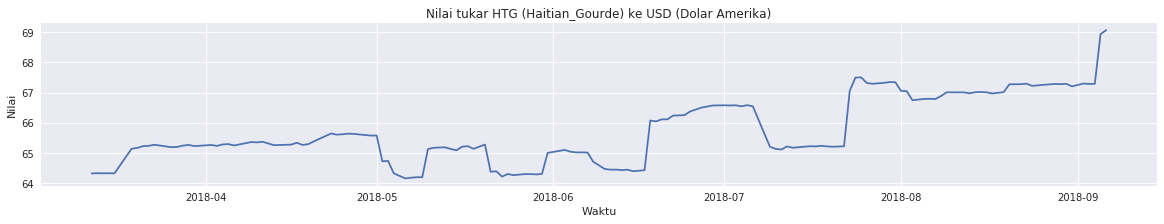

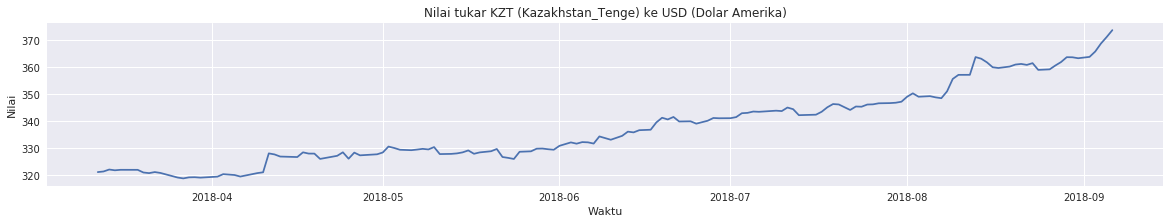

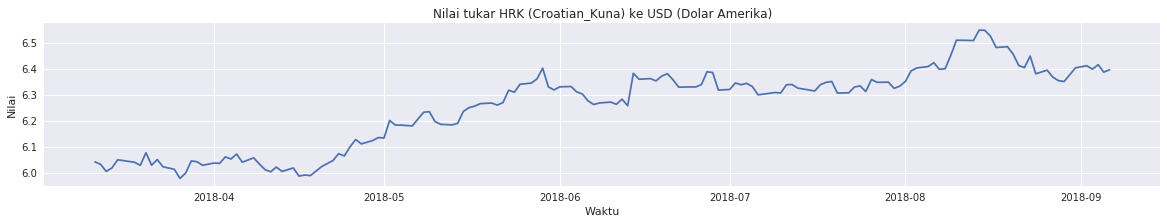

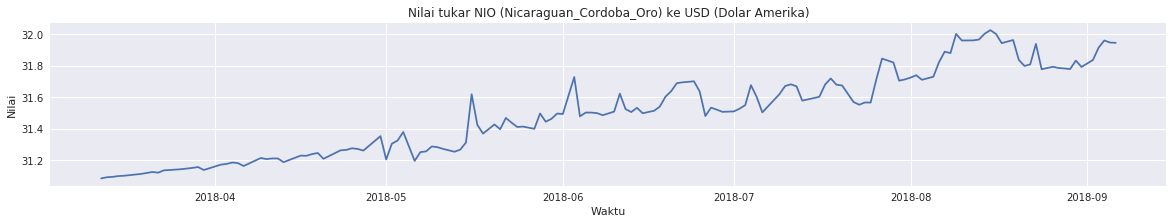

In [6]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

for i, code in enumerate(list(results.keys())[0:4]):
    pd_data = pd.DataFrame.from_dict(results[code])
    pd_data['date'] = pd.to_datetime(pd_data['date'])
    plt.figure(figsize=(20, 3))
    plt.plot(pd_data['date'], pd_data['currency'])
    negara = dictkeys_from_value(country_codes, code)
    plt.ylabel('Nilai')
    plt.xlabel('Waktu')
    plt.title("Nilai tukar {} ({}) ke USD (Dolar Amerika)".format(code,negara))
    plt.savefig('./currency/{}_to_USD.jpg'.format(code))
    